In [35]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

## Build the architecture of LeNet5 from Scratch

There are two main steps after that. 

First is initializing the layers that we are going to use in our CNN inside __init__ , and 

Then the other is to define the sequence in which those layers will process the image. This is defined inside the forward function.

In [8]:
batch_size = 64
num_classes = 10

![Imgur](https://imgur.com/yrIrojL.png)

In [9]:
class LeNet5(nn.Module):
    def __init__(self,num_classes):
        super(LeNet5,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(0,0)), #Layer 1
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2)) #Layer-2
        )                
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0)), #Layer 3
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)) #Layer 4
        )
        self.fc = nn.Linear(400, 120) # Layer 5
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84) # Layer 6
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes) # Layer 7 or Final Layer
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        # print('output after layer2', output.size()) # torch.Size([32, 16, 5, 5]
        output = output.reshape(output.size(0), -1) # See note below for this line
        # print('output after resize', output.size()) # torch.Size([32, 400])
        output = self.fc(output)
        output = self.relu(output)
        output = self.fc1(output)
        output = self.relu1(output)
        output = self.fc2(output)
        return output
        

Note the nn.Linear function's argument => `torch.nn.Linear(in_features, out_features, bias=True)`

in_features – size of each input sample (i.e. size of x)
out_features – size of each output sample (i.e. size of y)
bias – If set to False, the layer will not learn an additive bias. Default: True

### Loading the Dataset

Using torchvision , we will load the dataset as this will allow us to perform any pre-processing steps easily.

The images are greyscale, all with a size of 28x28, and is composed of 60,000 training images and 10,000 testing images.

In [10]:
# Define relevant variables for the ML task

''' Keeping num_classes at 10, as this will be the output shape from the final Layer of the LeNet5 Neural Network model, because, the output layer will have 10 output neurons, since the MNIST data has 10 classes for each of the 10 numerical digits. '''

train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

 the MNIST data can't be used as it is for the LeNet5 architecture. The LeNet5 architecture accepts the input to be 32x32 and the MNIST images are 28x28. We can fix this by resizing the images, normalizing them using the pre-calculated mean and standard deviation (available online), and finally storing them as tensors.

In [11]:
learning_rate = 0.001

model = LeNet5(num_classes).to(device)

#Setting the loss function
criterion = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_dataloader)

In [29]:
print('Length of train_dataloader ', len(train_dataloader))
print('Length of test_dataloader ', len(test_dataloader))

Length of train_dataloader  938
Length of test_dataloader  157


In [42]:
def train(model, criterion, optimizer, num_epochs=10):
    total_training_loss = []
    total_step = len(train_dataloader)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_dataloader):  
            images = images.to(device)
            labels = labels.to(device)
            
            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            # Backward and optimize
            optimizer.zero_grad() # Clear the past gradient by set the gradients to zero before every update
            loss.backward() #  calculate the new gradients
            # print('images.size ', images.size(0))
            running_loss += loss.item() * images.size(0)
            optimizer.step() # we update the weights 
            
                
            if (i+1) % 400 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                
        epoch_loss = running_loss / len(train_dataloader)
        
        total_training_loss.append(epoch_loss)
    return total_training_loss

In [43]:
total_training_loss = train(model, criterion, optimizer, num_epochs=30)

Epoch [1/3], Step [400/938], Loss: 0.2052
Epoch [1/3], Step [800/938], Loss: 0.0055
Epoch [2/3], Step [400/938], Loss: 0.0350
Epoch [2/3], Step [800/938], Loss: 0.0222
Epoch [3/3], Step [400/938], Loss: 0.0006
Epoch [3/3], Step [800/938], Loss: 0.0012


In [44]:
total_training_loss

[1.3321929221934596, 1.079675040208548, 0.918493939132101]

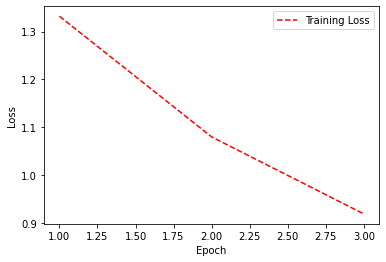

In [45]:

epoch_count = range(1, len(total_training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, total_training_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();